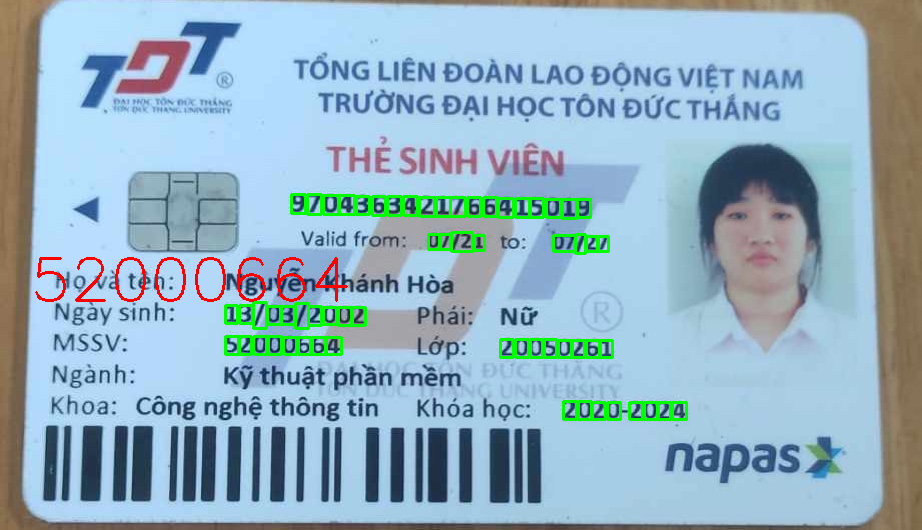

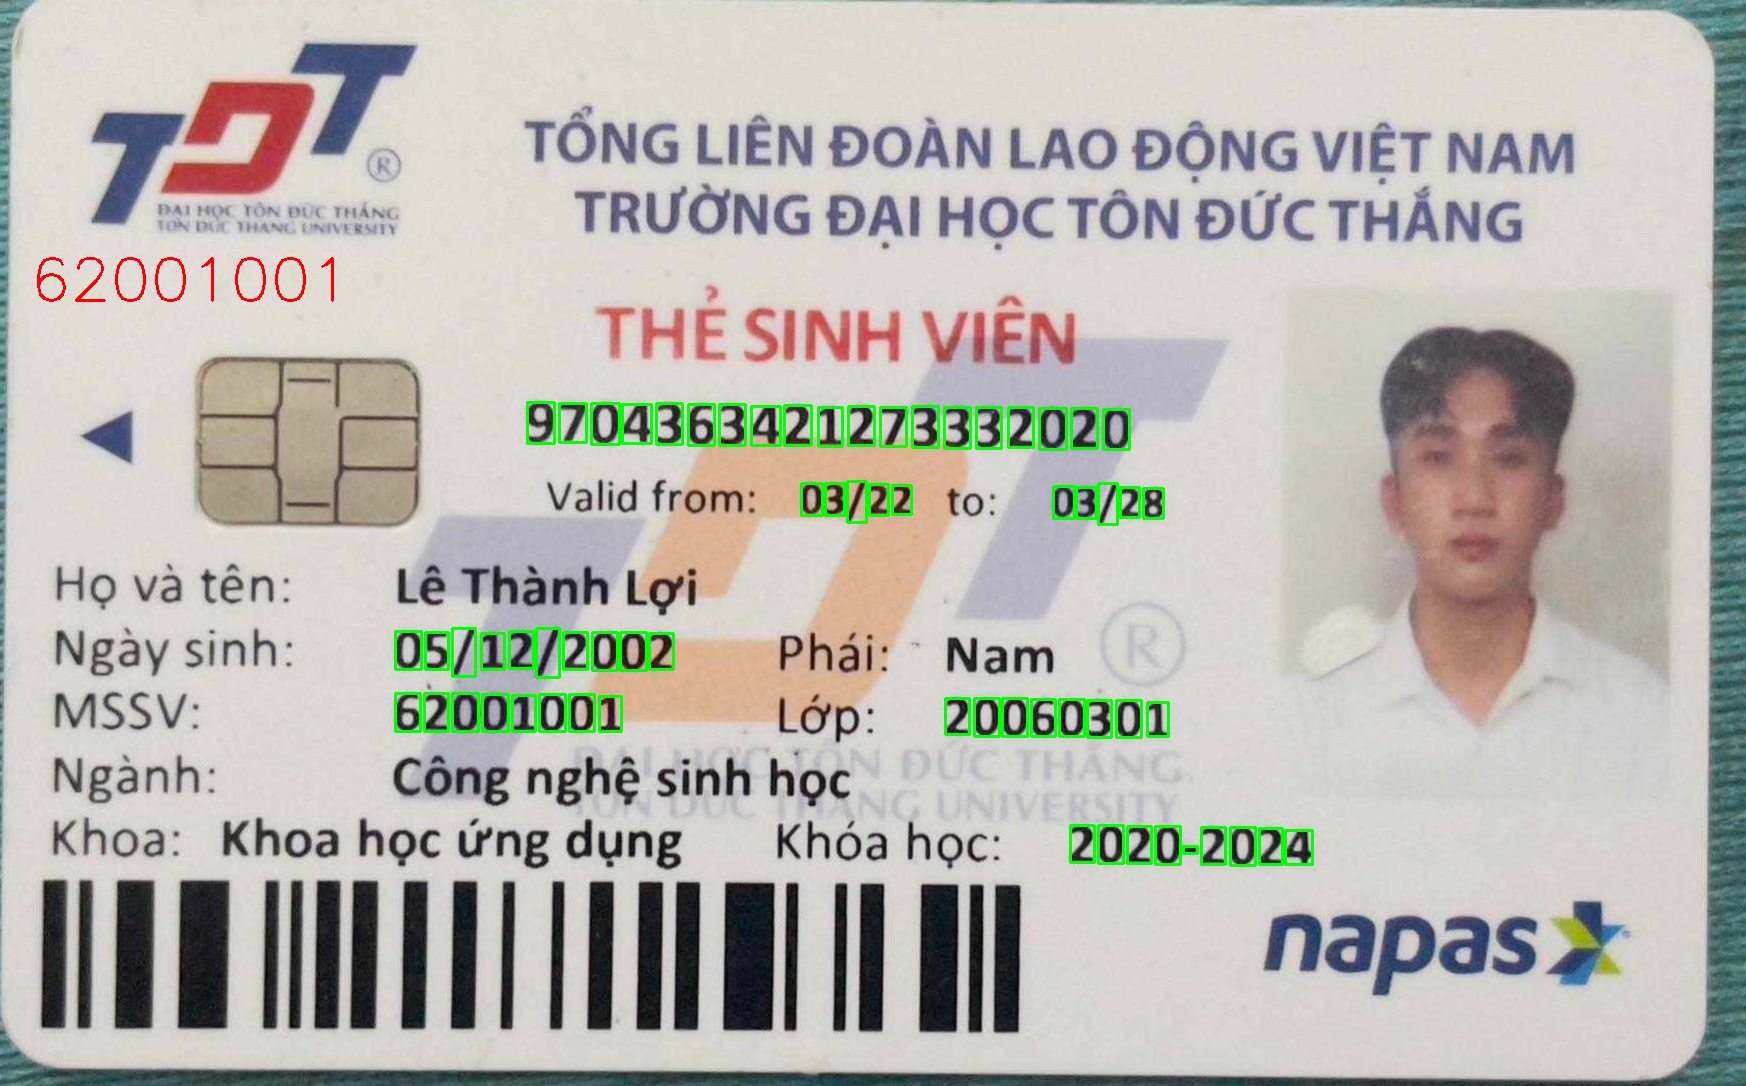

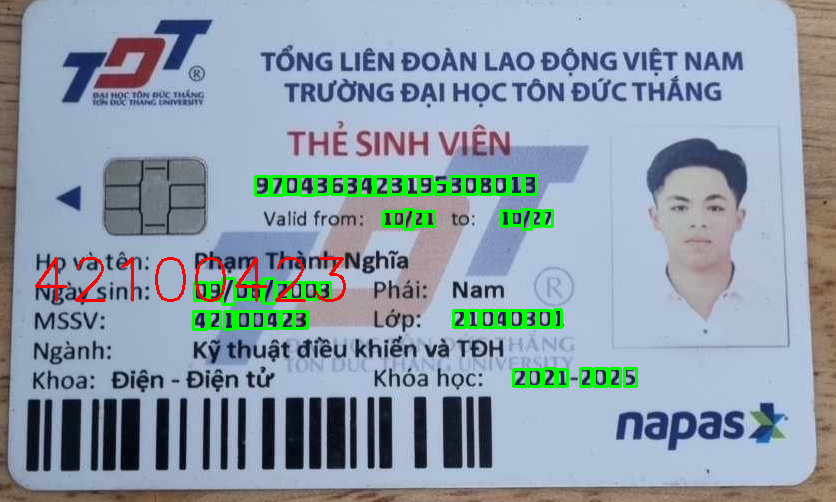

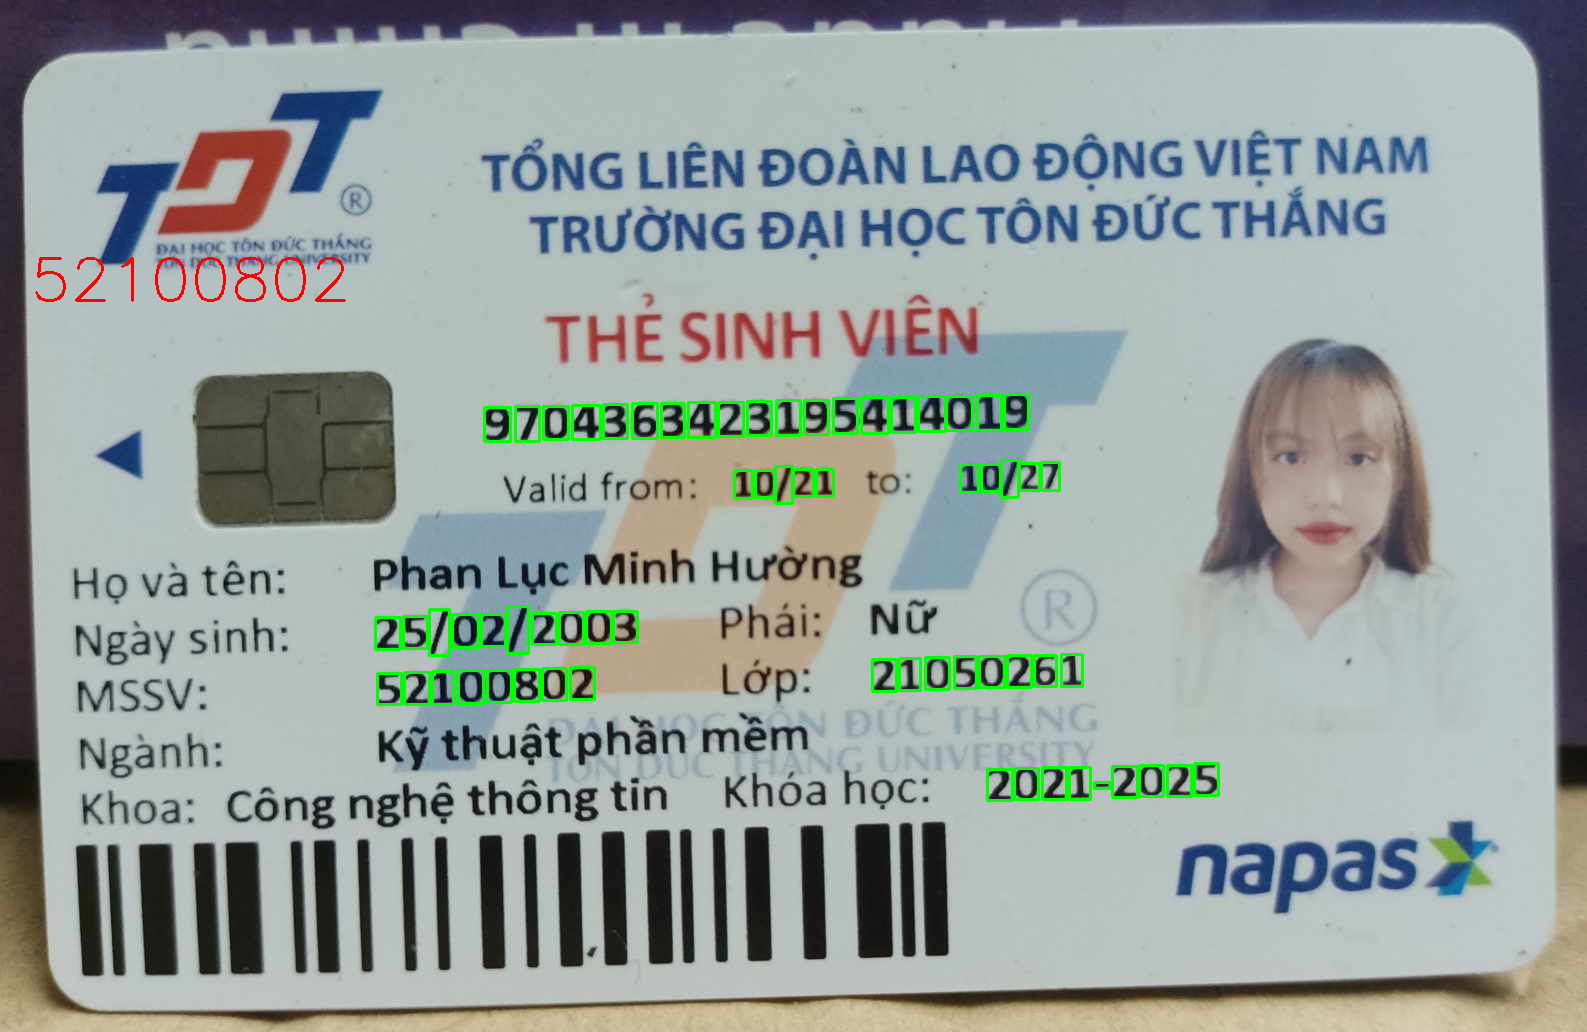

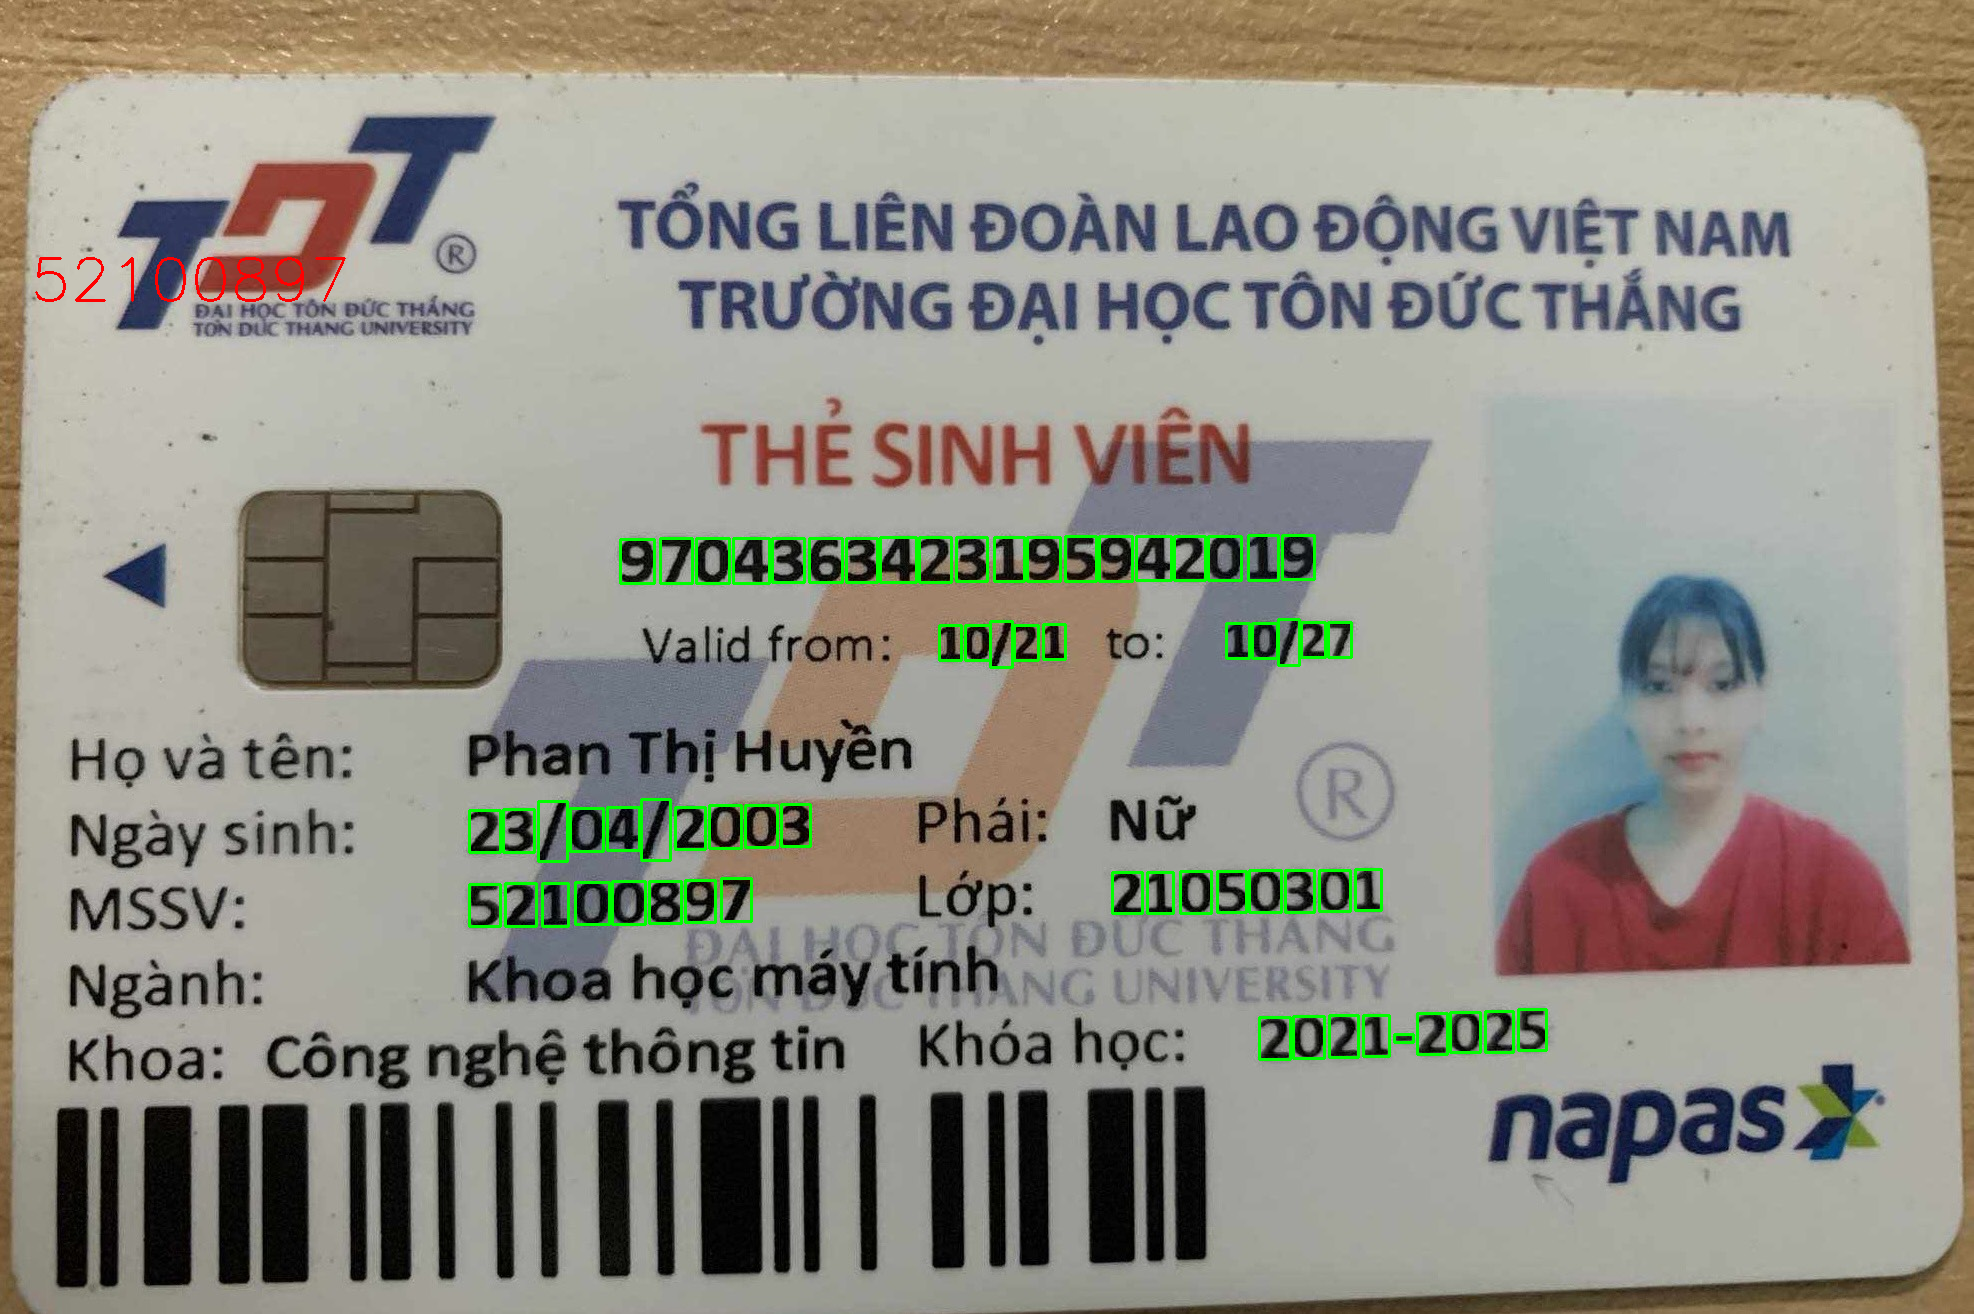

In [ ]:
import cv2
import os
import numpy as np
import operator
from google.colab.patches import cv2_imshow

MIN_CONTOUR = 45
WIDTH_RESIZE = 20
HEIGHT_RESIZE = 30

class ContourData:
  contour = None
  rect = None
  intX = 0
  intY = 0
  intWith = 0
  intHeight = 0
  area = 0

  def calculate4Point(self):
    [intX, intY, intWidth, intHeight] = self.rect
    self.intX = intX
    self.intY = intY
    self.intWidth = intWidth
    self.intHeight = intHeight

  def checkContour(self):
    if self.area < MIN_CONTOUR: return False
    return True

def readCropFolder(crop_folder, coordinate_folder):
  max_h = 0  # Lưu trữ chiều cao lớn nhất
  max_w = 0  # Lưu trữ chiều rộng lớn nhất
  kernel_size = (1,1)
  cropImg_path = []
  coordinate_lst = []

  for file_name in os.listdir(crop_folder):
      if file_name.startswith("crop_") and file_name.endswith(".png"):
        # Xác định chỉ số từ tên tệp
        idx = file_name.split('_')[1].split('.')[0]

        cropImg_path.append(os.path.join(crop_folder, file_name))

        # Đọc tọa độ từ tệp tương ứng
        coordinate_path = os.path.join(coordinate_folder, f'coordinate_{idx}.txt')
        try:
          with open(coordinate_path, 'r') as f:
            coordinate_data = f.read()
            coordinates = coordinate_data.split(',')
            x = int(coordinates[0].split('=')[1])
            y = int(coordinates[1].split('=')[1])
            w = int(coordinates[2].split('=')[1])
            h = int(coordinates[3].split('=')[1])

            coordinate_lst.append((x, y, w, h))
            # Cập nhật max_h và max_w nếu cần
            max_h = max(max_h, h+y)
            max_w = max(max_w, w+x)
        except:
          print(f"Lỗi, không thể đọc tọa độ từ {coordinate_path}")
          continue
          #print(x, y, w, h)
      if max_h < 500 and 840 < max_w <= 850:
        kernel_size = (2,1)
      elif max_h < 500 and 830 < max_w <= 850:
        kernel_size = (3,1)
      elif 1500 < max_w <= 2000:
        kernel_size = (3,1)

  return kernel_size, cropImg_path, coordinate_lst


def main():
  output_folder = 'output'

  if not os.path.exists(output_folder):
      os.makedirs(output_folder)
  try:
    label = np.loadtxt("/content/drive/MyDrive/DIP/label.txt", np.float32)
  except:
    raise ValueError("Không thể mở file label.txt")

  try:
    train = np.loadtxt("/content/drive/MyDrive/DIP/train.txt", np.float32)
  except:
    raise ValueError("Không thể mở file train.txt")

  # đầu vào của svm yêu cầu kiểu số nguyên nên chuyển label thành số nguyên
  label = label.reshape((label.size, 1)).astype(np.int32)

  # cài đặt và train svm
  svm = cv2.ml.SVM_create()
  svm.setType(cv2.ml.SVM_C_SVC)
  svm.setKernel(cv2.ml.SVM_LINEAR)
  svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
  svm.train(train, cv2.ml.ROW_SAMPLE, label)


  image_path = "/content/drive/MyDrive/DIP/data"
  for img in os.listdir(image_path):
    image_path = "/content/drive/MyDrive/DIP/data"
    img_path = os.path.join(image_path, img)
    image = cv2.imread(img_path)

    if image is None:
      raise ValueError("Invalid image file or path")

    # Bước 2: Tiền xử lý ảnh
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5, 5), 0, borderType = cv2.BORDER_DEFAULT)
    #blur = cv2.equalizeHist(blur)
    bw = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Chọn kernel với chiều rộng lớn hơn để kết nối các đường
    kernel_size = (15, 1)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)

    # Bước 3: Thực hiện phép đóng: Dilate và sau đó close
    bw_closed = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, kernel)

    # Tìm các contours cho mỗi dòng văn bản
    contours, _ = cv2.findContours(bw_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Lọc contours để chọn những contours có chiều rộng ít nhất gấp 2 lần chiều cao của nó
    filtered_contours = [cnt for cnt in contours if (cv2.boundingRect(cnt)[2] / cv2.boundingRect(cnt)[3]) >= 2.0]

    def contour_sorting_key(contour):
        x, y, w, h = cv2.boundingRect(contour)
        return (-y, x)  # Sắp xếp theo y lớn nhất đầu tiên và từ x nhỏ nhất đến lớn nhất

    # Sắp xếp các contours
    sorted_contours = sorted(filtered_contours, key=contour_sorting_key)
    #sorted_contours = filtered_contours
    padding = 3
    for contour in sorted_contours:
        x, y, w, h = cv2.boundingRect(contour)
        x, y, w, h = (x-padding, y-padding, w+padding, h+padding)
        #print(f"with: {x+w}, height: {y+h}")
        #cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        #cv2_imshow(image)

    # Tạo thư mục 'crop' và 'coordinate' nếu chưa tồn tại
    crop_folder = os.path.join(output_folder, 'crop')
    coordinate_folder = os.path.join(output_folder, 'coordinate')

    if not os.path.exists(crop_folder):
        os.makedirs(crop_folder)

    if not os.path.exists(coordinate_folder):
        os.makedirs(coordinate_folder)

    # Kiểm tra xem thư mục có tồn tại không
    if os.path.exists(crop_folder) and os.path.isdir(crop_folder):
        # Lặp qua tất cả các tệp tin và thư mục con trong thư mục này
        for filename in os.listdir(crop_folder):
            file_path = os.path.join(crop_folder, filename)
            try:
                # Nếu là một tệp tin, xóa nó
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                # Nếu là một thư mục, xóa thư mục (và tất cả nội dung bên trong)
                elif os.path.isdir(file_path):
                    os.rmdir(file_path)
            except Exception as e:
                print(f'Không thể xóa {file_path}. Lý do: {e}')
    else:
        print(f"Thư mục '{crop_folder}' không tồn tại hoặc không phải là một thư mục.")

    # Kiểm tra xem thư mục có tồn tại không
    if os.path.exists(coordinate_folder) and os.path.isdir(coordinate_folder):
        # Lặp qua tất cả các tệp tin và thư mục con trong thư mục này
        for filename in os.listdir(coordinate_folder):
            file_path = os.path.join(coordinate_folder, filename)
            try:
                # Nếu là một tệp tin, xóa nó
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                # Nếu là một thư mục, xóa thư mục (và tất cả nội dung bên trong)
                elif os.path.isdir(file_path):
                    os.rmdir(file_path)
            except Exception as e:
                print(f'Không thể xóa {file_path}. Lý do: {e}')
    else:
        print(f"Thư mục '{coordinate_folder}' không tồn tại hoặc không phải là một thư mục.")

    # Lặp qua các contours và lưu chúng vào thư mục 'crop' và tọa độ vào thư mục 'coordinate'
    for idx, contour in enumerate(sorted_contours):
        x, y, w, h = cv2.boundingRect(contour)
        x, y, w, h = (x - padding, y - padding, w + padding, h + padding)

        # Lưu contour vào thư mục 'crop'
        cropped_img = image[y:y + h, x:x + w]
        if cropped_img is not None and cropped_img.size > 0:
            cv2.imwrite(os.path.join(crop_folder, f'crop_{idx}.png'), cropped_img)
        else:
            pass

        # Lưu tọa độ vào thư mục 'coordinate' trên Google Drive
        with open(os.path.join(coordinate_folder, f'coordinate_{idx}.txt'), 'w') as f:
            f.write(f'Contour {idx}: x={x}, y={y}, width={w}, height={h}')

    kernel_size, cropImg_lst, coordinate_lst = readCropFolder(crop_folder, coordinate_folder)
    #print(cropImg_lst)
    dict_Coor_text = {}

    for idx, cropImg_path in enumerate(cropImg_lst):
      cropped_img = cv2.imread(cropImg_path)

      if cropped_img is None:
        print(f"Lỗi, không thể đọc ảnh {cropImg_path}")

      x, y, w, h = coordinate_lst[idx][0], coordinate_lst[idx][1], coordinate_lst[idx][2], coordinate_lst[idx][3]
      allContours, validContours = [], []

      # xử lý ảnh
      imgGray = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2GRAY)
      imgBlurred = cv2.GaussianBlur(imgGray, (3, 3), 0, borderType = cv2.BORDER_DEFAULT)

      imgThresh = cv2.adaptiveThreshold(imgBlurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

      kernel = np.ones(kernel_size, np.uint8)
      imgThresh = cv2.erode(imgThresh, kernel, iterations=1)
      imgThresh = cv2.dilate(imgThresh, kernel, iterations=1)

      imgThreshCopy = imgThresh.copy()

      # print(imgThreshCopy.shape)

      # print(hei, wid)
      # cv2_imshow(imgThreshCopy)
      if imgThreshCopy.shape[0] > 100:
        continue

      #cv2_imshow(imgThreshCopy)
      contours, _ = cv2.findContours(imgThreshCopy, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

      # khởi tạo các đối tượng contour
      for contour in contours:
          contourData = ContourData()
          contourData.contour = contour
          contourData.rect = cv2.boundingRect(contourData.contour)
          contourData.calculate4Point()
          contourData.area = cv2.contourArea(contourData.contour)
          allContours.append(contourData)

      # lọc ra các contour hợp lệ
      for contourData in allContours:
        if contourData.checkContour():
          #if contourData.intWidth < contourData.intHeight and abs(contourData.intWidth - contourData.intHeight) < 20:
            validContours.append(contourData)

      # sort theo X
      validContours.sort(key = operator.attrgetter("intX", "intY"))
      strCurrentChar = ""

      for contourData in validContours:
        imgROI = imgThresh[contourData.intY : contourData.intY + contourData.intHeight,
                          contourData.intX : contourData.intX + contourData.intWidth]

        #cv2_imshow(imgROI)

        imgROIResized = cv2.resize(imgROI, (WIDTH_RESIZE, HEIGHT_RESIZE))
        npaROIResized = imgROIResized.reshape((1, WIDTH_RESIZE * HEIGHT_RESIZE))
        npaROIResized = np.float32(npaROIResized)

        # dùng SVM để predict
        retval, npaResults = svm.predict(npaROIResized)
        strCurrentChar += str(chr(int(npaResults[0][0])))

      # print(strCurrentChar)

      letters = [char for char in strCurrentChar if char.isalpha()]

      if len(letters) == 1:
        strCurrentChar = strCurrentChar.replace(letters[0], '', 1)

      if len(letters) == 2 and len(strCurrentChar) > 7:
        strCurrentChar = strCurrentChar.replace(letters[0], '', 1)
        strCurrentChar = strCurrentChar.replace(letters[1], '', 1)

      if len(strCurrentChar) >= 3 and all(char.isdigit() for char in strCurrentChar):
        for contourData in validContours:
            cv2.rectangle(image,
                          (contourData.intX + x, contourData.intY + y),
                          (contourData.intX + contourData.intWidth + x, contourData.intY + contourData.intHeight + y),
                          (0, 255, 0), 2)  # Màu xanh lá và độ dày đường viền là 2
      if len(strCurrentChar) == 8 and all(char.isdigit() for char in strCurrentChar):
        dict_Coor_text[(contourData.intX, contourData.intY)] = strCurrentChar

    # Sắp xếp lại key trong dict_Coor_text theo giá trị tăng dần của tọa độ X
    sorted_dict_Coor_text = {k: v for k, v in sorted(dict_Coor_text.items(), key=lambda item: item[0][0])}

    # Lấy giá trị từ sorted_dict_Coor_text
    text_to_display = ""
    if len(sorted_dict_Coor_text) == 2:
        text_to_display = list(sorted_dict_Coor_text.values())[0]
    elif len(sorted_dict_Coor_text) > 2:
        text_to_display = list(sorted_dict_Coor_text.values())[1]

    # Hiển thị giá trị trên hình ảnh
    cv2.putText(image, text_to_display, (30, 300), cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 2)

    cv2_imshow(image)

if __name__ == "__main__":
  main()